### Chain using LANGGRAPH

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

#### How to use chat messages as our graph state
##### Messages

- We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
- These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.



In [3]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

In [4]:
### lets create a messages list to maintain a converstion history

messages = [AIMessage(content=f"Hello, how can I help you today?", name="LLM")]
messages.append(HumanMessage(content="What are the best places to visit in the world?", name="User"))
messages.append(AIMessage(content="Which countries are You intrested in to travel?", name="LLM"))
messages.append(HumanMessage(content="I am interested in visiting Switzerland and Norway.", name="User"))

In [5]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLM

Hello, how can I help you today?
================================ Human Message =================================
Name: User

What are the best places to visit in the world?
================================== Ai Message ==================================
Name: LLM

Which countries are You intrested in to travel?
================================ Human Message =================================
Name: User

I am interested in visiting Switzerland and Norway.


In [6]:
### Lets create a chat model

### Chat Model

In [7]:
from langchain_groq import ChatGroq
chat = ChatGroq(
    model="qwen-qwq-32b")

### Lets call the model with the messages list
response = chat.invoke(messages)

In [8]:
response.pretty_print()

================================== Ai Message ==================================


<think>
Okay, the user is asking for the best places to visit in Switzerland and Norway. Let me start by recalling the key attractions in each country.

For Switzerland, the Alps come to mind first. Places like Interlaken with its adventure activities, Lucerne for its old town and Chapel Bridge, and Zermatt for Matterhorn views. Also, Geneva as a cultural hub and the Jungfraujoch "Top of Europe." Don't forget the lakes like Lake Geneva and Lucerne. Maybe mention some unique spots like the Rhine Falls.

Now for Norway. The fjords are a must, so Geirangerfjord and Nærøyfjord. The Northern Lights in Tromsø, and the midnight sun in summer. Bergen with the Bryggen Hanseatic wharf and Flåm Railway. Oslo's cultural spots like the Viking Ship Museum and Munch's artworks. The Lofoten Islands for dramatic landscapes and hiking.

I need to structure the response clearly, separating Switzerland and Norway into secti

In [9]:
response.response_metadata

{'token_usage': {'completion_tokens': 1155,
  'prompt_tokens': 70,
  'total_tokens': 1225,
  'completion_time': 2.719515201,
  'prompt_time': 0.007669336,
  'queue_time': 0.225684643,
  'total_time': 2.727184537},
 'model_name': 'qwen-qwq-32b',
 'system_fingerprint': 'fp_28178d7ff6',
 'finish_reason': 'stop',
 'logprobs': None}

In [10]:
### Lets cover the Tools

### Tools

In [11]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [12]:
chat

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10b22c620>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10b326a50>, model_name='qwen-qwq-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [13]:
chat_with_tool = chat.bind_tools([add])

In [14]:
response1 = chat_with_tool.invoke([HumanMessage(content="What is 2+2?", name="User")])

In [15]:
response1.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  add (4xjjrsman)
 Call ID: 4xjjrsman
  Args:
    a: 2
    b: 2


In [16]:
response1.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': '4xjjrsman',
  'type': 'tool_call'}]

#### Using meassage as state

In [17]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    messages:list[AnyMessage]

In [18]:
### Reducer

from langgraph.graph.message import add_messages
from typing import Annotated

class stateclass(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [19]:
#### Reducer with messages

In [20]:
initial_message = [AIMessage(content="Hello, how can I help you today?", name="LLM")]
initial_message.append(HumanMessage(content="What are the best places to visit in the world?", name="User"))
initial_message

[AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, name='LLM'),
 HumanMessage(content='What are the best places to visit in the world?', additional_kwargs={}, response_metadata={}, name='User')]

In [21]:
ai_message = [AIMessage(content="Which countries are You intrested in to travel?", name="LLM")]
ai_message

[AIMessage(content='Which countries are You intrested in to travel?', additional_kwargs={}, response_metadata={}, name='LLM')]

In [22]:
### Reducers add_messages is to append instead of override
add_messages(initial_message,ai_message)

[AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, name='LLM', id='95bf1941-c227-49b6-a86f-62512147c825'),
 HumanMessage(content='What are the best places to visit in the world?', additional_kwargs={}, response_metadata={}, name='User', id='d400eb05-3fc3-42be-b02d-a757897fb285'),
 AIMessage(content='Which countries are You intrested in to travel?', additional_kwargs={}, response_metadata={}, name='LLM', id='314ad9bf-3766-49c2-8d4f-a1a5f4150399')]

In [23]:
## chatbot node functionality
def llm_tool(state:stateclass):
    return {"messages":[chat_with_tool.invoke(state["messages"])]}

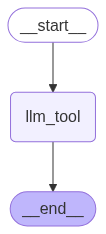

In [24]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(stateclass)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
## invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (kemya5vq5)
 Call ID: kemya5vq5
  Args:
    a: 2
    b: 2


In [26]:
tools=[add]

In [27]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(stateclass)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()



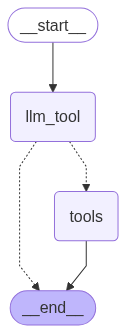

In [28]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [31]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (fp3dh6m7q)
 Call ID: fp3dh6m7q
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [30]:
messages=graph.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

Machine Learning (ML) is a subset of Artificial Intelligence (AI) that focuses on developing algorithms and statistical models enabling computers to improve their performance at specific tasks *without explicit step-by-step instructions*. Instead, ML systems learn patterns from data, make predictions, or decisions based on that data.

### Key Concepts:
1. **Types of Learning**:
   - **Supervised Learning**: Uses labeled data (e.g., predicting house prices using features like size and location).
   - **Unsupervised Learning**: Finds hidden patterns in unlabeled data (e.g., customer segmentation).
   - **Reinforcement Learning**: Learns through trial and error by maximizing rewards (e.g., training a AI to play a game).

2. **Core Components**:
   - **Data**: Raw input (images, text, numbers) used to train